In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm

## Load Data

In [33]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")
r_dataroot = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/R_data")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [6]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists1 = pd.read_csv(data_dir / "centroid-choroid_centroid2.csv", index_col="subid")
dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists1 = choroid_dists1.rename(columns=dists_newcols)
choroid_dists1_z = choroid_dists1.apply(stats.zscore, nan_policy="omit")

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")

ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

From `compute_exposures2.py`. This is what we want:

In [4]:
mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")
mni_dists['struct'] = hips_thomas_ref
mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_exposures3.csv", index_col="index")
# choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-choroid_centroid.csv", index_col="subid")

## Functions

In [21]:
def regress_all_nuclei2(model_data, covariates, pred, structs):
    pvals = {}
    coefs = {}
    se = {}

    if not isinstance(pred, Callable):
        predictor = pred
        def pred(*args, **kwargs):
            return predictor

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{struct} ~ {pred(struct)} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[pred(struct)]
        coefs[struct] = res.params[pred(struct)]
        se[struct] = res.HC0_se[pred(struct)]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results

def dist_name(struct):
    return f"{struct}_dist"

In [ ]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
model_data = df_z.join([df_thomas_z, choroid_dists])

subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

subids_remove = set(subids_remove)

In [60]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
model_data = df_z.join([df_thomas_left_z, choroid_dists])
# model_data = df.join([df_thomas, choroid_dists])

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()
model_data = model_data[model_data['dz_type5'].isin(["PMS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]
for i, row in ventricle_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "ventricle_dist"] = row[ind]

save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
save_data.to_csv(r_dataroot / "melted_data_for_R_PMS_z_left.csv", index=False)

In [55]:
subids_remove

{1107, 1276, 1457, 1482, 2007}

In [32]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
# model_data = df.join([df_thomas, choroid_dists])
model_data = df_z.join([df_thomas_z, choroid_dists])

check = model_data["2"].abs()
check[check > 4].index.values

array([1107, 2007])

## Analysis

In [70]:
hips_thomas_ref

index
1     THALAMUS_1
2           AV_2
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

In [ ]:
model_data = df_z.join([df_thomas_left_z, choroid_dists_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
model_data = model_data.loc[~model_data.index.isin([1011]), :]
covariates = "Female + age + tiv"
structs = hips_thomas_ref[~hips_thomas_ref.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# structs = hips_thomas_ref[hips_thomas_ref.index.isin(thalamic_nuclei)]

regression_results = regress_all_nuclei2(model_data, covariates, dist_name, structs)
# regression_results['dists'] = choroid_dists
regression_results

,struct,coef,pvals,se,p_fdr,coef_sig
2,AV_2,0.000915,0.989240,0.054722,0.989240,0.0
4,VA_4,0.010790,0.869274,0.070567,0.917567,0.0
5,VLa_5,0.043032,0.541753,0.066016,0.767442,0.0
6,VLP_6,-0.031440,0.608997,0.056678,0.771397,0.0
7,VPL_7,-0.156045,0.029433,0.101300,0.296586,0.0
8,Pul_8,-0.011955,0.777533,0.041633,0.869008,0.0
9,LGN_9,0.165160,0.031220,0.083724,0.296586,0.0
10,MGN_10,-0.054588,0.391603,0.062313,0.706380,0.0
11,CM_11,-0.089962,0.229261,0.077256,0.622279,0.0
12,MD_Pf_12,0.054178,0.341684,0.066808,0.706380,0.0


In [92]:
mni_dists.loc[thalamic_nuclei, 'left_exposure'].sort_values()

index
8      8.712833
7     13.337370
10    17.274308
11    18.029122
9     19.527532
12    20.743111
6     20.982216
5     25.154024
2     28.724859
4     29.301275
Name: left_exposure, dtype: float64

In [110]:
model_data = df_z.join([df_thomas, choroid_dists])
model_data = model_data[model_data['dz_type5'] == "PMS"]
model_data = model_data.loc[~model_data.index.isin([1011]), :]
ind = 9
formula = f"{hips_thomas_ref[ind]} ~ {hips_thomas_ref[ind]}_dist + age + Female + THALAMUS_1"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  LGN_9   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     36.40
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           4.49e-18
Time:                        18:22:44   Log-Likelihood:                -452.25
No. Observations:                  95   AIC:                             914.5
Df Residuals:                      90   BIC:                             927.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1913     42.163     -0.099      0.9

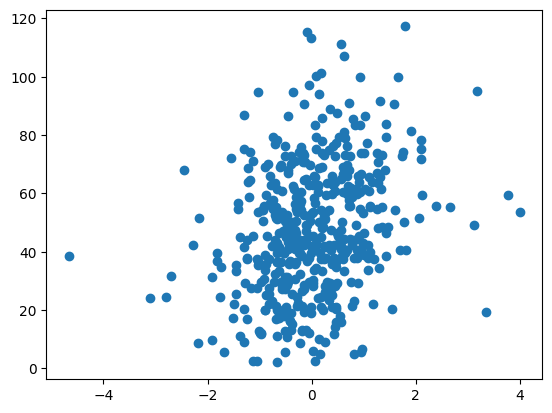

In [28]:
model_data = df.join([df_thomas_left, choroid_dists_z])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data = model_data.loc[~model_data.index.isin([2007]), :]
ind = 2
dist_name = f"{hips_thomas_ref[ind]}_dist"
struct = hips_thomas_ref[ind]
plt.scatter(model_data[dist_name], model_data[struct])

In [16]:
model_data.sort_values(by=dist_name, ascending=False)[choroid_dists.columns]

,AV_2_dist,VA_4_dist,VLa_5_dist,VLP_6_dist,VPL_7_dist,Pul_8_dist,LGN_9_dist,MGN_10_dist,CM_11_dist,MD_Pf_12_dist,Hb_13_dist,MTT_14_dist,Acc_26_dist,Cau_27_dist,Cla_28_dist,GPe_29_dist,GPi_30_dist,Put_31_dist,RN_32_dist
subid,,,,,,,,,,,,,,,,,,,
2007,6.635233,12.255736,18.359029,16.952630,28.929300,33.359362,40.389340,36.257239,25.153545,19.201000,28.594574,23.822429,27.864284,14.839433,36.136106,21.487895,22.953584,27.587220,31.605359
1457,45.703498,46.158380,40.026216,35.237861,24.800805,19.622289,26.308158,25.183928,30.569224,35.019751,30.644224,49.196044,70.036679,60.165919,57.693229,51.959115,49.010882,53.729472,40.270967
1500,43.499482,43.810251,37.522907,33.029938,22.559502,17.955293,25.544978,25.197994,28.541531,33.039017,30.041977,46.046555,65.561639,57.006798,53.033350,47.977816,45.270165,49.165752,39.702991
1482,46.490688,44.369711,38.078793,34.307212,22.752291,17.560543,22.662068,24.153902,29.473330,34.788486,32.127497,46.767450,66.624590,58.760269,51.941349,47.994965,45.124910,48.950724,39.460254
1247,43.299335,42.378928,36.174580,32.294979,22.023974,16.821623,22.548893,22.436057,28.146844,32.909882,30.040901,44.076007,63.186475,56.109690,52.182159,45.739733,42.961123,47.338624,36.648003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,28.645364,29.239016,23.824740,18.400167,9.992344,4.764154,19.532098,13.012943,13.121529,17.798550,16.812668,31.942301,55.265415,44.999734,46.733950,38.933860,35.410639,42.129627,25.284040
2269,27.960945,26.498945,21.474542,17.762300,8.727735,4.555233,16.220011,12.132936,12.699493,17.445253,15.709221,28.699232,48.973713,42.012792,43.919490,32.891370,30.036946,36.598265,23.565195
1235,27.166445,26.530176,21.640144,17.356041,8.501486,4.080737,16.242912,11.315377,12.474569,16.743244,15.241203,27.968106,51.538368,42.406984,45.905589,34.011312,31.781629,38.198270,23.913864


(array([ 54., 339., 160.,  15.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([ 4.080737  ,  7.00859947,  9.93646194, 12.86432442, 15.79218689,
        18.72004936, 21.64791183, 24.5757743 , 27.50363678, 30.43149925,
        33.35936172]),
 <BarContainer object of 10 artists>)

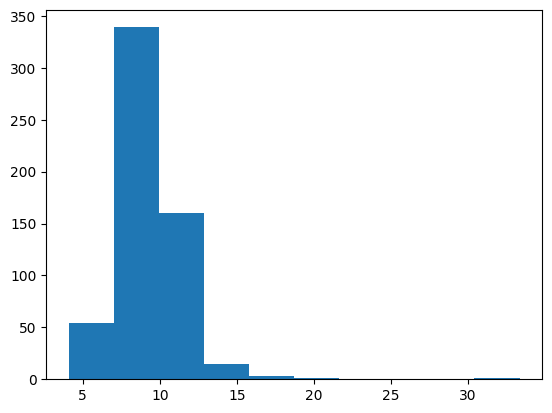

In [10]:
ind = 8
dist_name = f"{hips_thomas_ref[ind]}_dist"
struct = hips_thomas_ref[ind]
plt.hist(choroid_dists[dist_name])

In [104]:
model_data.sort_values(by="Pul_8_dist")

,subject,sz_onset,dzdur,MSSS,gMSSS,ARMSS,sex,age,obs_start_date,obs_end_date,...,MD_Pf_12_dist,Hb_13_dist,MTT_14_dist,Acc_26_dist,Cau_27_dist,Cla_28_dist,GPe_29_dist,GPi_30_dist,Put_31_dist,RN_32_dist
subid,,,,,,,,,,,,,,,,,,,,,
2021,ms2021,11/1/2020,-1.301885,NaN,NaN,-0.532257,Female,-1.039421,8/30/2019,8/30/2019,...,20.882586,19.336411,34.341098,52.313848,43.998270,45.343293,36.896778,34.224295,39.861209,29.184167
1267,ms1267,12/27/2019,-1.084497,0.376012,0.151097,0.490655,Female,-1.755396,1/5/2021,1/5/2021,...,22.416332,18.423869,36.152331,58.384649,51.299097,52.252689,42.631012,39.501381,46.404346,29.431954
1477,ms1477,3/28/2021,-1.106668,-0.380526,-0.467743,-0.099323,Female,-1.962233,1/15/2022,1/15/2022,...,17.993560,18.669202,32.840351,52.772773,42.512913,46.879048,36.470242,34.570958,40.559010,29.989264
2001,ms2001,1/1/2011,-0.595915,-0.425267,-0.359028,-0.977924,Female,0.570860,12/22/2016,12/22/2016,...,15.771339,14.228181,29.819238,53.049016,43.907741,49.172222,38.375681,36.429051,42.983207,26.469768
1364,ms1364,6/1/2010,-0.485328,NaN,NaN,NaN,Female,-1.441162,7/5/2017,7/5/2017,...,21.016838,18.195327,35.705125,56.720618,50.081460,53.190906,42.230788,39.616385,46.549528,29.968650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,ms1072,1/1/2015,-0.844937,-0.014459,0.013113,-0.052635,Female,-0.938212,6/15/2018,6/15/2018,...,27.561817,20.807361,37.264459,61.938615,56.416127,66.759256,52.383268,48.914150,59.773203,31.557970
2007,ms2007,6/1/2005,0.042460,-0.852345,-0.844065,-0.850591,Female,0.224143,11/8/2017,11/8/2017,...,17.527839,21.345345,25.114760,40.626305,33.803083,52.181034,36.006878,35.056401,43.645553,28.786253
1068,ms1068,1/1/1996,1.082353,-0.067335,0.126009,0.524610,Female,0.765764,12/20/2018,12/20/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  3.,  18.,  29.,  62., 111., 118.,  80.,  37.,   8.,   1.]),
 array([  62.970985 ,  391.9818211,  720.9926572, 1050.0034933,
        1379.0143294, 1708.0251655, 2037.0360016, 2366.0468377,
        2695.0576738, 3024.0685099, 3353.079346 ]),
 <BarContainer object of 10 artists>)

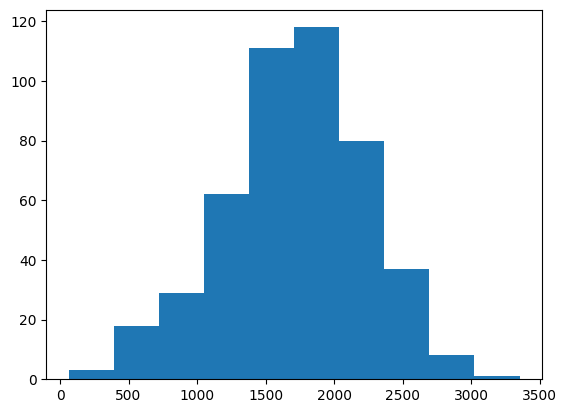

In [102]:
plt.hist(model_data['choroid_volume'])